In [1]:
# Utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time 
import random

# Neural Nets
import tensorflow as tf
import tensorflow_probability as tfp
from keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

# Config 
import sys
import os
import pickle
from dotenv import load_dotenv
import warnings

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Data
from mkt_data_ETL.data_load_and_transform import get_data, get_top_mkt_cap_stocks

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:

# =============================================================================
# REPRODUCIBILITY SETUP - Set seeds for deterministic results
# =============================================================================
def set_seeds(seed=42):
    """
    Set seeds for reproducible results across all random number generators.
    
    Args:
        seed (int): The seed value to use for all random number generators
    """
    # Set Python's built-in random seed
    random.seed(seed)
    
    # Set NumPy seed
    np.random.seed(seed)
    
    # Set TensorFlow seeds
    tf.random.set_seed(seed)
    
    # Set environment variables for deterministic behavior
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Configure TensorFlow for deterministic operations
    tf.config.experimental.enable_op_determinism()
    
    print(f"All seeds set to: {seed}")
    print("Deterministic operations enabled for reproducible results.")

# Set the seed for reproducible results
SEED = 42
set_seeds(SEED)

def verify_seed_settings():
    """
    Verify that all seed settings are properly configured.
    This function can be called to check reproducibility setup.
    """
    print("=== Reproducibility Verification ===")
    print(f"SEED value: {SEED}")
    print(f"PYTHONHASHSEED: {os.environ.get('PYTHONHASHSEED', 'Not set')}")
    print(f"TF_DETERMINISTIC_OPS: {os.environ.get('TF_DETERMINISTIC_OPS', 'Not set')}")
    print(f"TF_CUDNN_DETERMINISTIC: {os.environ.get('TF_CUDNN_DETERMINISTIC', 'Not set')}")
    print("=====================================")

# Uncomment the line below to verify seed settings
# verify_seed_settings()

All seeds set to: 42
Deterministic operations enabled for reproducible results.


In [3]:
# Get data 
stock_prices_df, stock_shares_amount_df, mkt_cap_df, spx_index, removed_companies = get_data()
top_100_mkt_cap_df, top_100_mkt_cap_prices_df=get_top_mkt_cap_stocks(stock_prices_df=stock_prices_df, 
stock_mkt_cap_df=mkt_cap_df)


# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))

# Rolling volatility
window_size = 252*2 # 2 years
Sigma_df= stocks_returns.rolling(window=window_size).cov(pairwise=True)
Sigma_df = Sigma_df.dropna()

# Get the first date in the cleaned DataFrame
START_DATE = Sigma_df.index.get_level_values(0)[0]

# Filter dataframes to start from START_DATE
top_100_mkt_cap_df = top_100_mkt_cap_df.loc[START_DATE:]
stocks_returns     = stocks_returns.loc[START_DATE:]
stock_prices_df    = stock_prices_df.loc[START_DATE:]

assets = stocks_returns.columns
dates  = stocks_returns.index

n = len(assets)
T = len(dates)
Sigma_t = np.empty((T, n, n))

# Fill array with each rolling covariance matrix
for i, t in enumerate(dates):
    Sigma = Sigma_df.loc[t].reindex(index=assets, columns=assets).values
    Sigma_t[i] = Sigma


# Market Weights
mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

# Market portfolio return
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

In [4]:
def compute_relative_covariance(sigma: np.ndarray, pi: np.ndarray) -> np.ndarray:
    """
    Calcula a matriz de covariância relativa τ_ij^π(t) com base na covariância σ_ij(t)
    e no vetor de pesos do portfólio π(t).
    
    Args:
        sigma (np.ndarray): Matriz de covariância dos ativos (n x n).
        pi (np.ndarray): Vetor de pesos do portfólio (n,).

    Returns:
        np.ndarray: Matriz de covariância relativa τ^π (n x n).
    """
    # Covariância ativo i com portfólio: sigma_iπ = sigma @ pi
    sigma_i_pi = sigma @ pi        # (n,)
    sigma_pi_pi = pi.T @ sigma @ pi  # escalar

    # Matriz τ_ij^π = σ_ij - σ_iπ - σ_jπ + σ_ππ
    n = len(pi)
    tau = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            tau[i, j] = sigma[i, j] - sigma_i_pi[i] - sigma_i_pi[j] + sigma_pi_pi
    return tau

print("initializing tau_t calculation")
start_time = time.time()

tau_t = np.empty((T, n, n))
for t in range(T):
    tau_t[t] = compute_relative_covariance(Sigma_t[t], mkt_portfolio_weights.iloc[t].values)

end_time = time.time()
elapsed_seconds = end_time - start_time
print(f"Elapsed time: {elapsed_seconds:.2f} seconds")


# Copying data generated previously 
mu_t_df = mkt_portfolio_weights.copy()
R_t_df =  stocks_returns.copy()
 
mu_tf                   = tf.convert_to_tensor(mu_t_df.values, dtype=tf.float32) 
mkt_ret_tf              = tf.convert_to_tensor(mkt_return.values, dtype=tf.float32)            
R_t_tf                  = tf.convert_to_tensor(R_t_df.values, dtype=tf.float32)
tau_t_tf                = tf.convert_to_tensor(tau_t, dtype=tf.float32)
mkt_portfolio_weights   = tf.convert_to_tensor(mkt_portfolio_weights.values, dtype=tf.float32)


indices = np.arange(len(mu_tf))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False, random_state=SEED)

# Split datasets

# Train
mu_train            = tf.gather(mu_tf, train_idx)
mkt_ret_train       = tf.gather(mkt_ret_tf, train_idx)
stock_returns_train = tf.gather(R_t_tf, train_idx)
tau_train           = tf.gather(tau_t_tf, train_idx)

# Test
mu_test            = tf.gather(mu_tf, test_idx)
mkt_ret_test       = tf.gather(mkt_ret_tf, test_idx)
stock_returns_test = tf.gather(R_t_tf,  test_idx)
tau_test           = tf.gather(tau_t_tf, test_idx)

initializing tau_t calculation
Elapsed time: 11.81 seconds


In [5]:

# Curriculum Training Samples
D_1 = mu_t_df.loc[pd.to_datetime('2006-01-01'):pd.to_datetime('2011-01-01')].index
D_2 = mu_t_df.loc[pd.to_datetime('2011-01-01'):pd.to_datetime('2018-01-01')].index
D_3 = mu_t_df.loc[pd.to_datetime('2018-01-01'):].index



D_sizes = {
    "D1": len(D_1),
    "D2": len(D_1) + len(D_2),
    "D3": len(D_1) + len(D_2) + len(D_3),
}

# Dicionário para armazenar subconjuntos
curriculum_data = {}

# Aplica os cortes crescentes sobre train_idx
for name, size in D_sizes.items():
    subset_idx = train_idx[:size]
    
    curriculum_data[name] = {
        'mu': tf.gather(mu_tf, subset_idx),
        'mkt_ret': tf.gather(mkt_ret_tf, subset_idx),
        'stock_ret': tf.gather(R_t_tf, subset_idx),
        'tau': tf.gather(tau_t_tf, subset_idx),
    }

In [6]:
@register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=100, **kwargs):
        """
        Initializes the PINN model with an architecture optimized to learn
        smooth functions (C^2).

        Args:
            input_dim (int): The dimensionality of the network input (default: 100).
        """
        super(PINN, self).__init__(**kwargs)

        self.initializer_bias = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=SEED)
        self.initializer = tf.keras.initializers.GlorotNormal(seed=SEED)
        self.l2_regularizer = tf.keras.regularizers.l2(0.001)
        self.input_dim = input_dim


        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.input_dim ,)),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
        ])
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus', bias_initializer=tf.keras.initializers.RandomUniform(0.1, 0.5,seed=SEED))

    @tf.function
    def call(self, inputs):
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

In [7]:
def main(epochs, save_dir):
    
    @tf.function
    def loss_function(mu, G_pred, HESS_G_pred, tau, adp_lambda1, adp_lambda2):
        """
        Custom loss function for the PINN.

        Args:
            mu (tf.Tensor): Market weights.
            G_pred (tf.Tensor): Value of G predicted by the network.
            grad_log_G_pred (tf.Tensor): Gradient of log of G predicted by the network.
            HESS_G_pred (tf.Tensor): Hessian of G predicted by the network.
            ret (tf.Tensor): Stock returns.
            ret_mkt (tf.Tensor): The market return.
            tau (tf.Tensor): Relative covariance matrix.

        Returns:
            _type_: Loss values
        """

        #########################
        # # Drift Calculation # #
        #########################
        T = tf.shape(mu)[0]

        mu_i = tf.expand_dims(mu, axis=2)     # (T, n, 1)
        mu_j = tf.expand_dims(mu, axis=1)     # (T, 1, n)

        # internal product μ_i μ_j: shape (T, n, n)
        mu_outer = mu_i * mu_j

        # elementwise: H * μ_i * μ_j * τ
        elementwise = HESS_G_pred * mu_outer * tau  # shape (T, n, n)

        # sum over i and j (last two dimensions)
        summed = tf.reduce_sum(elementwise, axis=[1, 2])  # shape (T,)
        g_t = -0.5 * summed / tf.squeeze(G_pred)

        # #########################
        # # # Drift integration # #
        # #########################
        base = tf.range(T)


        weights = tf.ones_like(g_t, dtype=g_t.dtype)
        if T % 2 == 1:  
            weights = tf.where(
                (base % 2 == 1) & (base != 0) & (base != T-1),
                tf.constant(4.0, dtype=g_t.dtype),
                weights
            )
            weights = tf.where(
                (base % 2 == 0) & (base != 0) & (base != T-1),
                tf.constant(2.0, dtype=g_t.dtype),
                weights
            )
            weights *= (1.0 / 3.0)
        else:  # Trapezoidal rule
            weights = tf.where(
                (base == 0) | (base == T-1),
                tf.constant(0.5, dtype=g_t.dtype),
                tf.constant(1.0, dtype=g_t.dtype)
            )
        int_g_t = tf.reduce_sum(weights * g_t)

        # #######################
        # # # Master Eq Error # #
        # #######################
        G0 = G_pred[0]
        GT = G_pred[-1]
        G_total_variation = tf.math.log(GT[0]) - tf.math.log(G0[0])
        right_hand_side = G_total_variation + int_g_t
                 
        fro_norm_hess = tf.norm(HESS_G_pred, ord='fro', axis=[1, 2])
        penalize_flatness = tf.reduce_mean(1.0 / (fro_norm_hess + 1e-3))  

        diffs = g_t[1:] - g_t[:-1]             # (T-1,)
        penalty_monotone = tf.reduce_mean(tf.nn.relu(-diffs))

        # positive right hand side penalty
        penalty_positive_right_hand_side = tf.nn.relu(-right_hand_side)

        # update total loss
        total_loss = (
            penalty_positive_right_hand_side
            + adp_lambda1 *  penalize_flatness
            + adp_lambda2 *  penalty_monotone
        )

        return total_loss, right_hand_side, int_g_t, penalty_monotone, penalty_positive_right_hand_side, penalize_flatness

    @tf.function
    def train_step(model, optimizer, x, tau):
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(x)
                G_pred = model(x)
                grad_G = tape1.gradient(G_pred, x) 

            H_G = tape2.batch_jacobian(grad_G, x)  # Hessian of G(x)
            total_loss, right_hand_side, g_t, penalty_monotone, penalty_positive_right_hand_side, penalize_flatness = loss_function(mu=x, 
                G_pred= G_pred,
                HESS_G_pred= H_G, 
                tau= tau, 
                adp_lambda1= self_adp_lambda1, 
                adp_lambda2= self_adp_lambda2
            )
        
        gradient_nn_wt = tape2.gradient(total_loss, model.trainable_variables)
        (gradient_self_adp) = tape2.gradient(total_loss, [self_adp_lambda1, 
                                                        self_adp_lambda2
                                                        ]
                                            )

        optimizer.apply_gradients(zip(gradient_nn_wt, model.trainable_variables))

        return  total_loss, gradient_self_adp, grad_G, g_t, right_hand_side, penalty_monotone, penalty_positive_right_hand_side, penalize_flatness


    ###########################################################
    ## Initialize the model and the optimizer and parameters ##
    ###########################################################

    model =  PINN(input_dim=100)


    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=epochs*3,     
        decay_rate=0.1,              
        staircase=False              
    )
    optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.95)
    optimizer_self_adp1 = tf.keras.optimizers.Adam(1.0, beta_1=0.9, beta_2=0.99)
    optimizer_self_adp2 = tf.keras.optimizers.Adam(1.0, beta_1=0.9, beta_2=0.99)
    
    ###########################################
    ## Initialize self adaptative parameters ##
    ###########################################

    self_adp_lambda1 = tf.cast(tf.ones([1,1]), dtype=tf.float32)
    self_adp_lambda2 = tf.cast(tf.ones([1,1]), dtype=tf.float32)
    

    self_adp_lambda1 = tf.Variable(self_adp_lambda1)
    self_adp_lambda2 = tf.Variable(self_adp_lambda2)
    
    #########################################
    ## Exit Training variables ##
    #########################################

    for D_i in curriculum_data.keys():
        mu_di = curriculum_data[D_i]['mu']
        tau_di = curriculum_data[D_i]['tau']
        
        G_snapshots = {}  # Estimated function snapshots

        #######################################
        ## Objects to store training metrics ##
        #######################################

        grad_norms_per_epoch = {}
        avg_loss_vect = []
        right_rand_side_vect_vec = []
        drift_per_batch_vect = []
        penalty_monotone_vect = []
        penalty_positive_right_hand_side_vect = []
        lambda_1_vect = []
        lambda_2_vect = []
        penalize_flatness_vect = []

    
        for epoch in range(1,epochs+1):

            ################
            ## Train Step ##
            ################

            total_loss, gradient_self_adp, grad_G, g_t, right_hand_side, penalty_monotone, penalty_positive_right_hand_side, penalize_flatness = train_step(model, optimizer, mu_di, tau_di)


            #####################################
            ## Update self-adaptive parameters ##
            #####################################

            optimizer_self_adp1.apply_gradients(zip([-gradient_self_adp[0]], [self_adp_lambda1]))
            optimizer_self_adp2.apply_gradients(zip([-gradient_self_adp[1]], [self_adp_lambda2]))


            self_adp_lambda1.assign(tf.math.softplus(self_adp_lambda1))
            self_adp_lambda2.assign(tf.math.softplus(self_adp_lambda2))

            grad_norms_per_epoch[str(epoch)] = tf.norm(grad_G, ord='euclidean', axis=1)

            avg_loss_vect.append(total_loss.numpy()[0,0])
            lambda_1_vect.append(self_adp_lambda1.numpy()[0,0])
            lambda_2_vect.append(self_adp_lambda2.numpy()[0,0])
            penalize_flatness_vect.append(penalize_flatness.numpy())

            penalty_monotone_vect.append(penalty_monotone.numpy())
            penalty_positive_right_hand_side_vect.append(penalty_positive_right_hand_side.numpy())
            drift_per_batch_vect.append(g_t.numpy())
            right_rand_side_vect_vec.append(right_hand_side.numpy())



            start_epoch = 50

            if epoch >= start_epoch:    
                G_snapshots[epoch] = model(mu_di, training=False).numpy().flatten()
            
            if epoch % 50 == 0 or epoch==1:
                print(
                    f"{D_i} | Epoch {epoch} | total_loss: {total_loss.numpy()[0,0]:8f} | "
                    f"lambda1: {self_adp_lambda1.numpy()[0,0]:2f}| "
                    f"lambda2: {self_adp_lambda2.numpy()[0,0]:2f} | "
                    f"excess_ret: {right_hand_side.numpy():5f} | "
                    f"int_g_t: {g_t.numpy():5f} | "
                    f"penalty_monotone: {penalty_monotone.numpy():5f} | "
                    f"penalty_positive_right_hand_side: {penalty_positive_right_hand_side.numpy():5f} | "
                    f"penalize_flatness: {penalize_flatness.numpy():5f} | "
                )
    
        #################################################
        ## Save the model weights and training metrics ##
        #################################################

        model.save(os.path.join(save_dir, f'port_gen_func_nn_{D_i}.keras'))
        
        # Save training metrics (dictionaries and vectors)
        with open(os.path.join(save_dir, f'training_metrics_{D_i}.pkl'), 'wb') as f:
            pickle.dump({
                'grad_norms_per_epoch': grad_norms_per_epoch,
                'avg_epoch_loss_vect': avg_loss_vect,
                'drift_per_batch_vect': drift_per_batch_vect,
                'right_rand_side_vect_vec': right_rand_side_vect_vec,
                'penalty_monotone_vect': penalty_monotone_vect,
                'penalty_positive_right_hand_side_vect': penalty_positive_right_hand_side_vect,
                'lambda_1_vect': lambda_1_vect,
                'lambda_2_vect': lambda_2_vect,
                'penalize_flatness_vect': penalize_flatness_vect,
                'G_snapshots': G_snapshots, 
            }, f)

        print(f"All {D_i} artifacts saved to {save_dir}")

    return model

if __name__ == "__main__":
    model1 = main(500, os.environ['SAVE_DIR'])

D1 | Epoch 1 | total_loss: 9.063938 | lambda1: 2.126927| lambda2: 1.313291 | excess_ret: 0.001304 | int_g_t: 0.000002 | penalty_monotone: 0.000000 | penalty_positive_right_hand_side: 0.000000 | penalize_flatness: 9.063938 | 
D1 | Epoch 50 | total_loss: 0.005372 | lambda1: 9.312502| lambda2: 4.413069 | excess_ret: 0.151590 | int_g_t: 0.002765 | penalty_monotone: 0.000000 | penalty_positive_right_hand_side: 0.000000 | penalize_flatness: 0.000577 | 
D1 | Epoch 100 | total_loss: 0.001727 | lambda1: 9.413486| lambda2: 8.600458 | excess_ret: 0.190859 | int_g_t: 0.005812 | penalty_monotone: 0.000000 | penalty_positive_right_hand_side: 0.000000 | penalize_flatness: 0.000183 | 
D1 | Epoch 150 | total_loss: 0.000777 | lambda1: 9.430465| lambda2: 17.133396 | excess_ret: 0.253922 | int_g_t: 0.011450 | penalty_monotone: 0.000000 | penalty_positive_right_hand_side: 0.000000 | penalize_flatness: 0.000082 | 
D1 | Epoch 200 | total_loss: 0.000320 | lambda1: 9.441895| lambda2: 34.132076 | excess_ret: 0.

In [8]:
loaded_model = tf.keras.models.load_model(os.path.join(os.environ['SAVE_DIR'], 'port_gen_func_nn_D3.keras'))

with open(os.path.join(os.environ['SAVE_DIR'], 'training_metrics_D3.pkl'), 'rb') as f:
    metrics = pickle.load(f)
    grad_norms_per_epoch = metrics['grad_norms_per_epoch']
    avg_epoch_loss_vect = metrics['avg_epoch_loss_vect']
    drift_per_batch_vect = metrics['drift_per_batch_vect']
    right_rand_side_vect_vec = metrics['right_rand_side_vect_vec']
    penalty_monotone_vect = metrics['penalty_monotone_vect']
    penalty_positive_right_hand_side_vect = metrics['penalty_positive_right_hand_side_vect']
    lambda_1_vect = metrics['lambda_1_vect']
    lambda_2_vect = metrics['lambda_2_vect']
    penalize_flatness_vect = metrics['penalize_flatness_vect']
    G_snapshots = metrics['G_snapshots']

print("Model and training metrics loaded successfully!")

Model and training metrics loaded successfully!


In [9]:
def load_metric_from_all_datasets(metric_name: str) -> dict:
    """
    Carrega uma métrica específica dos arquivos de métricas de treinamento D1 a D4.

    Args:
        metric_name (str): Nome da métrica a ser carregada.

    Returns:
        dict: Dicionário com as métricas carregadas, chaves sendo 'D1', 'D2', 'D3', 'D4'.
    """
    metrics_dict = {}
    for i in range(1, 4):
        file_path = os.path.join(os.environ['SAVE_DIR'], f'training_metrics_D{i}.pkl')
        with open(file_path, 'rb') as f:
            metrics = pickle.load(f)
            if metric_name not in metrics:
                raise KeyError(f"Métrica '{metric_name}' não encontrada em training_metrics_D{i}.pkl")
            metrics_dict[f'D{i}'] = metrics[metric_name]
    return metrics_dict

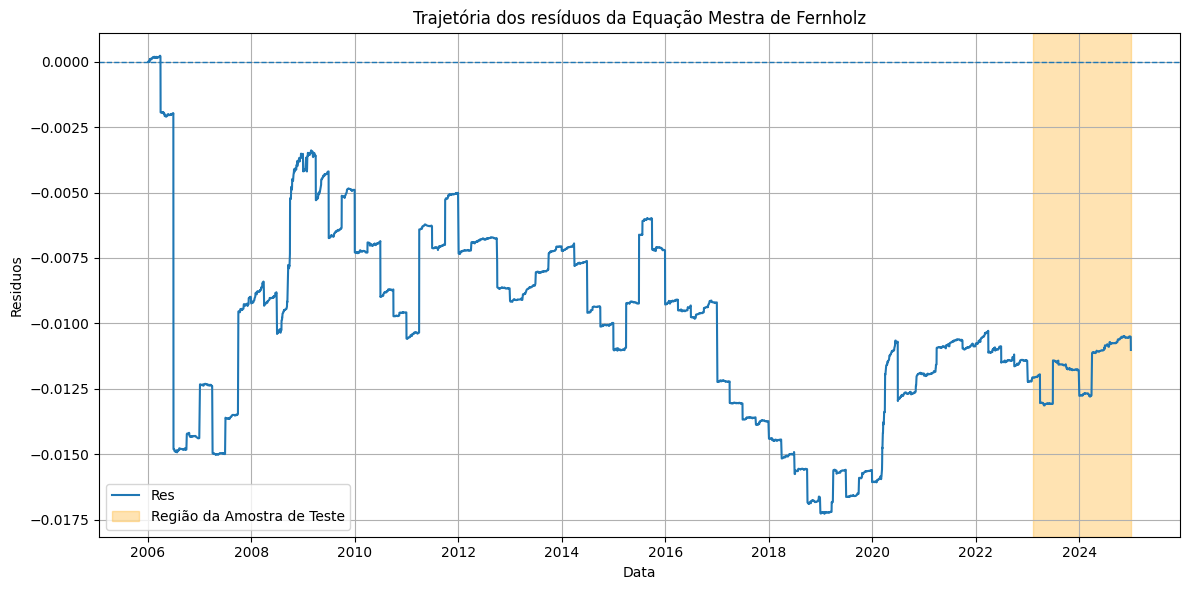

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

eps = 1e-7

# 1) G, grad log G, Hess(G)
with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(mu_tf)
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(mu_tf)
        G_pred = loaded_model(mu_tf, training=False)                 # (T,1), G>0 (idealmente garantir na arquitetura)
        log_G_pred = tf.math.log(G_pred + eps)                       # (T,1)
        grad_log_G = tape1.gradient(log_G_pred, mu_tf)               # (T,n)
        grad_G     = tape1.gradient(G_pred, mu_tf)                   # (T,n)
    H_G = tape2.batch_jacobian(grad_G, mu_tf)                        # (T,n,n)
# Simetrização numérica
H_G = 0.5*(H_G + tf.transpose(H_G, perm=[0,2,1]))
del tape1, tape2

# 2) g_t
def drift_series(mu, tau, HESS_G_pred, G_pred):
    mu_i = tf.expand_dims(mu, axis=2)              # (T,n,1)
    mu_j = tf.expand_dims(mu, axis=1)              # (T,1,n)
    elem = HESS_G_pred * (mu_i * mu_j) * tau       # (T,n,n)
    summed = tf.reduce_sum(elem, axis=[1,2])       # (T,)
    g_t = -0.5 * (summed / (tf.squeeze(G_pred,1) + eps))
    return g_t

g_t = drift_series(mu_tf, tau_t_tf, H_G, G_pred)   # (T,)

# Integração (trapézio) com Δt=1
mid = 0.5 * (g_t[1:] + g_t[:-1])
cum_int_g = tf.concat([tf.zeros_like(g_t[:1]), tf.cumsum(mid)], axis=0)   # (T,)

# 3) Portfólio funcional
inner_prod = tf.reduce_sum(mu_tf * grad_log_G, axis=1, keepdims=True)     # (T,1)
pi_t_tf = mu_tf * (grad_log_G + 1.0 - inner_prod)                         # (T,n)

# 4) LHS (log-wealth relativa) e RHS
pi_t_df = pd.DataFrame(pi_t_tf.numpy(), index=dates, columns=assets)

ret_pi = (pi_t_df.shift(1) * stocks_returns).sum(axis=1)                  # r^π_t
mkt_ret = (mu_t_df.shift(1) * stocks_returns).sum(axis=1)                   # r^μ_t (garanta mu_df alinhado a mu_tf)
lhs_cum = np.log1p(ret_pi).cumsum() - np.log1p(mkt_ret).cumsum()

logG = pd.Series(tf.math.log(tf.squeeze(G_pred) + eps).numpy(), index=dates)
rhs_cum = (logG - logG.iloc[0]) + pd.Series(cum_int_g.numpy(), index=dates)

residual_t = lhs_cum - rhs_cum

test_start = min(test_idx)
test_end = max(test_idx)

# ---------- 5) Plot do residual ----------
plt.figure(figsize=(12,6))
plt.plot(residual_t.index, residual_t.values, label="Res")

plt.axvspan(dates[test_start], dates[test_end], color='orange', alpha=0.3, label="Região da Amostra de Teste")


plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("Trajetória dos resíduos da Equação Mestra de Fernholz")
plt.xlabel("Data")
plt.ylabel("Residuos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [11]:
mu_i = tf.expand_dims(mu_tf, axis=2)     # (T, n, 1)
mu_j = tf.expand_dims(mu_tf, axis=1)     # (T, 1, n)

# internal product μ_i μ_j: shape (T, n, n)
mu_outer = mu_i * mu_j

# elementwise: H * μ_i * μ_j * τ
elementwise = H_G * mu_outer * tau_t_tf  # shape (T, n, n)

# sum over i and j (last two dimensions)
summed = tf.reduce_sum(elementwise, axis=[1, 2])  # shape (T,)
g_t = -0.5 * summed / tf.squeeze(G_pred)

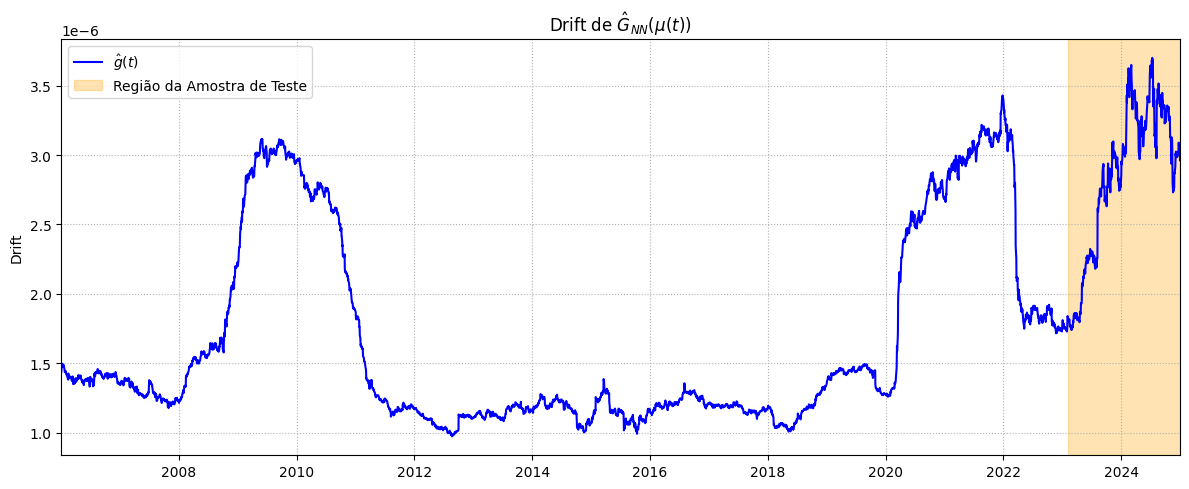

In [25]:
# Compute G_p_NN for the whole sample
G_p_nn_all = g_t.numpy().flatten()
dates = stocks_returns.index 

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.plot(dates, G_p_nn_all, label="$\hat{g}(t)$", color='blue')

# Highlight test region
test_start = min(test_idx)
test_end = max(test_idx)

plt.grid(linestyle=':')
ax.margins(x=0)

ax.set_title(r"Drift de $\hat{G}_{NN}(\mu(t))$")
ax.set_ylabel(r"Drift")
ax.axvspan(dates[test_start], dates[test_end], color='orange', alpha=0.3, label="Região da Amostra de Teste")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


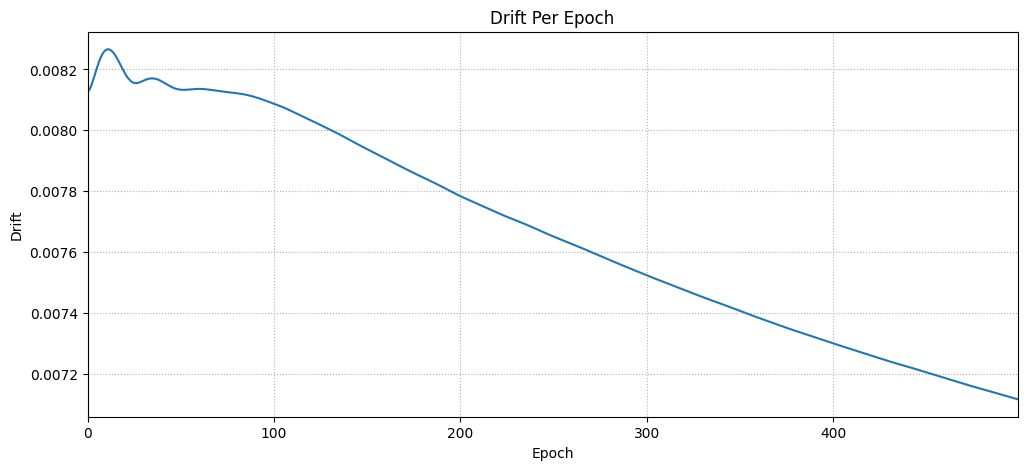

In [13]:
plt.figure(figsize=(12, 5))

plt.plot(drift_per_batch_vect)

plt.title('Drift Per Epoch')
plt.ylabel('Drift')
plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

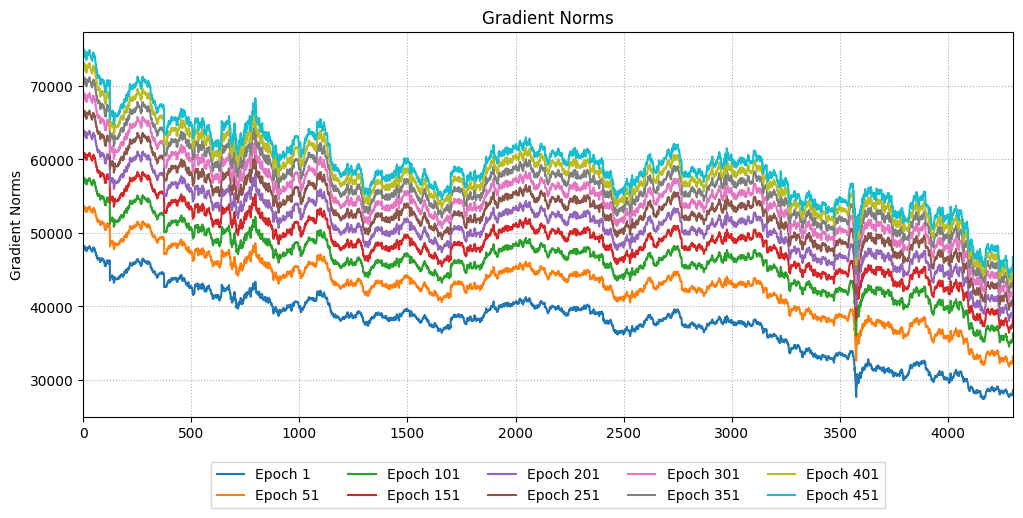

In [14]:
plt.figure(figsize=(12, 5))

# Get all keys and calculate step size for 10% intervals
keys = list(grad_norms_per_epoch.keys())
step = max(1, len(keys) // 10)  # Ensure at least 1, but aim for 10 curves

# Plot only every step-th key
for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(grad_norms_per_epoch[i], label=f'Epoch {i}')

plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel(None)
plt.title('Gradient Norms')
plt.ylabel('Gradient Norms')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=5)
plt.show()

In [15]:
from performance_metrics import plot_avg_epoch_loss
from performance_metrics import plot_G_nn_with_test_highlight, plot_cumulative_portfolios_performance
from performance_metrics import  calculate_dwp_portfolio_return, calculate_model_portfolio_return


target_vol = 0.1
p_value = 0.5
model_return = calculate_model_portfolio_return(loaded_model, mu_tf, R_t_tf)
# dwp_return   = calculate_dwp_portfolio_return(mkt_portfolio_weights, stocks_returns, p_value)

dates = stocks_returns.index 

# series_dict = {
#     'Market': mkt_return.values,
#     'Model': model_return.numpy().flatten(),
#     'DWP': dwp_return.values
# }


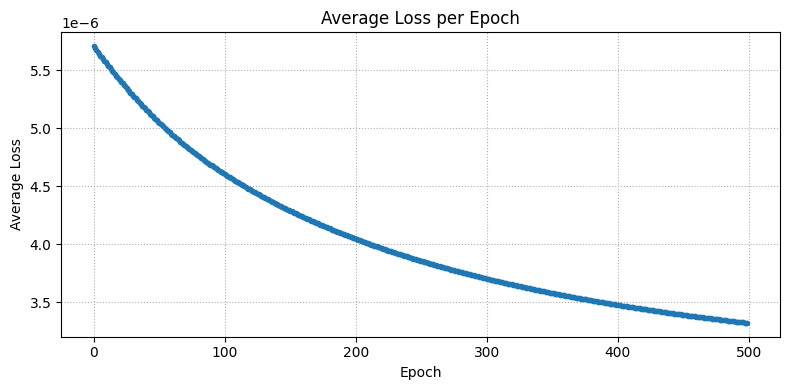

In [16]:
plot_avg_epoch_loss(avg_epoch_loss_vect)

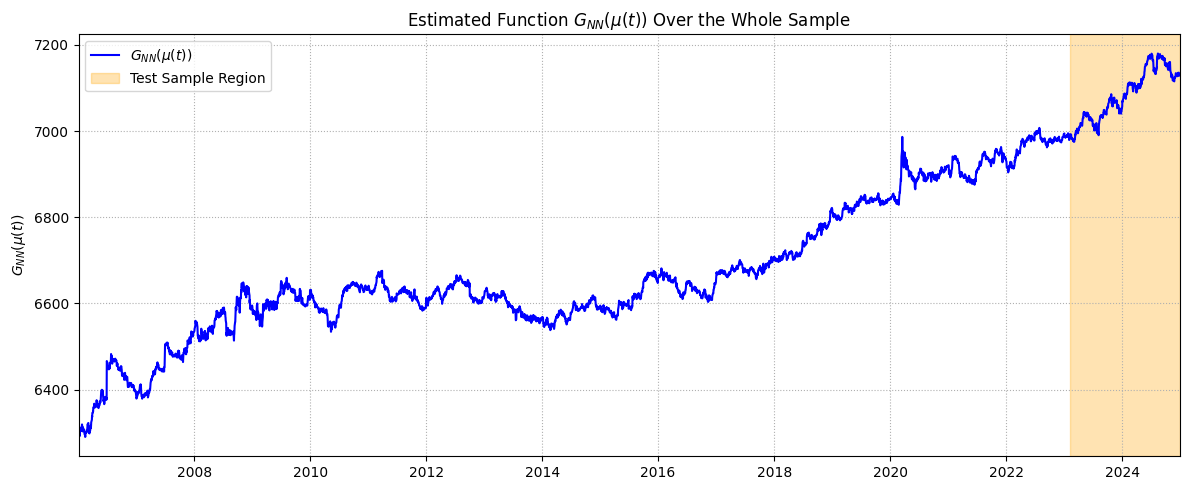

In [17]:
plot_G_nn_with_test_highlight(
    model=loaded_model,
    mu_tf=mu_tf,
    R_t_tf=R_t_tf,
    test_idx=test_idx,
    dates=dates
)

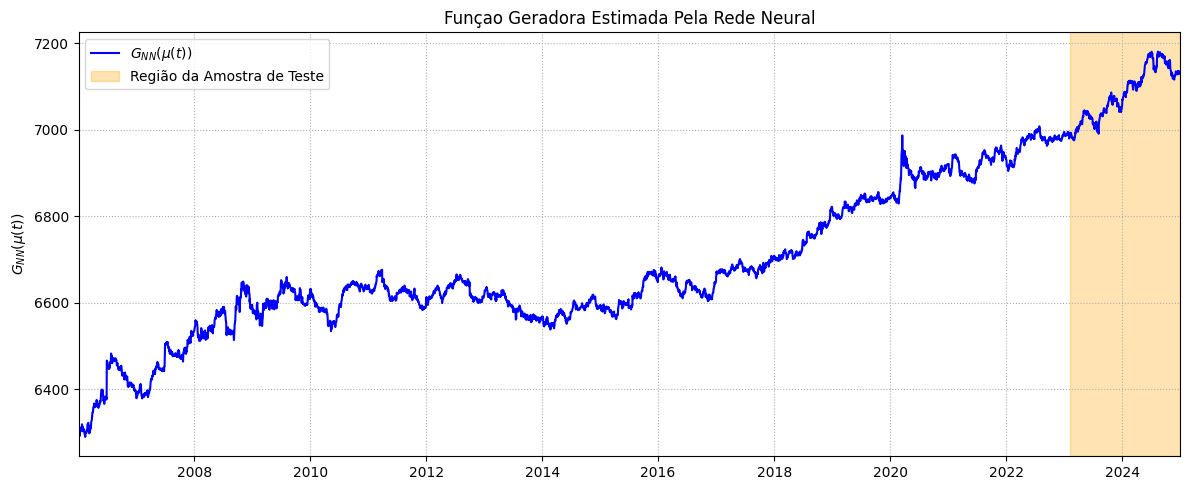

In [18]:
# Compute G_p_NN for the whole sample
G_p_nn_all = loaded_model(mu_tf, training=False).numpy().flatten()

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.plot(dates, G_p_nn_all, label="$G_{NN} ( \mu(t) )$", color='blue')

# Highlight test region
test_start = min(test_idx)
test_end = max(test_idx)

plt.grid(linestyle=':')
ax.margins(x=0)

ax.set_title("Funçao Geradora Estimada Pela Rede Neural")
ax.set_ylabel("$G_{NN}(\mu(t))$")
ax.axvspan(dates[test_start], dates[test_end], color='orange', alpha=0.3, label="Região da Amostra de Teste")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


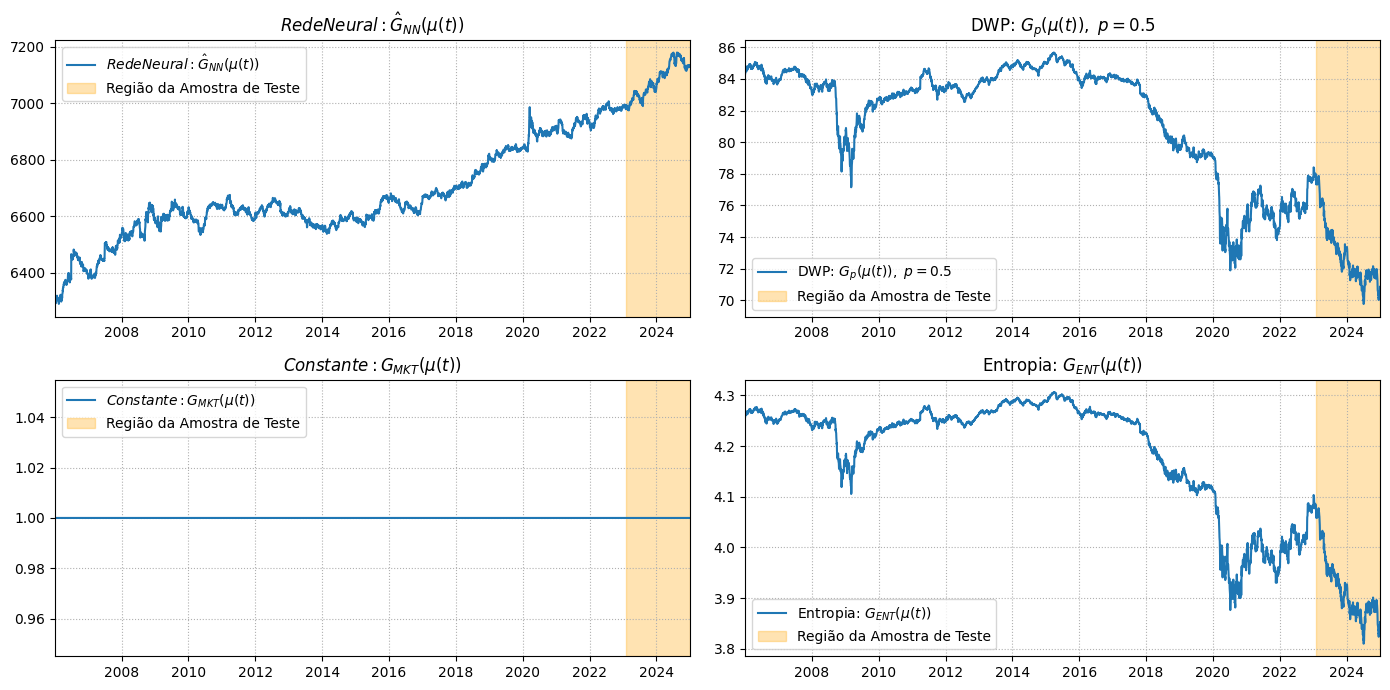

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Tensores -> NumPy (sem qualquer clipping)
mu_np = mu_tf.numpy()           # shape (T,n)
T, n = mu_np.shape

# G_NN ao longo do tempo

G_p_nn_all = loaded_model(mu_tf, training=False).numpy().flatten()

# ---------- Geradoras "duras" ----------
def G_dwp_p(mu, p):
    """
        Diversity Weighted Portfolio
    """
    s = np.sum(mu**p, axis=1)
    return s**(1.0/p)

def G_mkt(mu):
    """
    Market Portfolio
    """
    n = mu.shape[0]
    return n*[1]

def G_buy_and_hold(mu):
    """
      buy a fixed amount at the beginning of the time and hold it until the end
    """
    n = mu.shape[1]
    S = 1-0.5*np.sum(mu**2, axis=1)
    return S

def G_entropy(mu):
    """
        Entropoy wieghted portfolio
    """
    entropy = -np.sum(mu * np.log(mu), axis=1)
    return entropy

def G_ewp(mu):
    """
        Equal Weighted Portfolio
    """
    n = mu.shape[1]
    # S = np.prod(mu**(1.0/n), axis=1)
    S = 1- 0.5*np.sum( (mu - 1/n )**2, axis=1)
    return S

# alvo c para CWP (constante no tempo): use c = mu(0) (normalizado por segurança numérica)
c_const = mu_np[0].copy()
c_sum = c_const.sum()
if not np.isclose(c_sum, 1.0):
    c_const = c_const / c_sum  # apenas normalização (não altera zeros de mu_t)

# Avaliar séries
G_dwp_05 = G_dwp_p(mu_np, p=0.5)
G_mkt_ts = G_mkt(mu_np)
G_ent_ts = G_entropy(mu_np)


# Região de teste
test_start = int(np.min(test_idx))
test_end   = int(np.max(test_idx))

# ---------- Plot em GRID (5 subplots, escalas independentes) ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.ravel()

def plot_one(ax, y, title):
    ax.plot(dates, y, label=title)
    ax.axvspan(dates[test_start], dates[test_end], color='orange', alpha=0.3,
               label="Região da Amostra de Teste")
    ax.set_title(title)
    ax.margins(x=0)
    ax.grid(True, linestyle=':')
    ax.legend()

plot_one(axes[0], G_p_nn_all, r"$Rede Neural: \hat{G}_{NN}(\mu(t))$")
plot_one(axes[1], G_dwp_05,   r"DWP: $G_{p}(\mu(t)),\ p=0.5$")
plot_one(axes[2], G_mkt_ts,   r"$Constante: G_{MKT}(\mu(t))$")
plot_one(axes[3], G_ent_ts,   r"Entropia: $G_{ENT}(\mu(t))$")


plt.tight_layout()
plt.show()


In [20]:
# plot_cumulative_portfolios_performance(series_dict, dates,test_idx, target_vol=0.1)

## Test Sample Evaluation

In [21]:
target_vol = 0.1
p_value = 0.5
model_return = calculate_model_portfolio_return(loaded_model, mu_test, stock_returns_test)


power_p_transform = tf.pow(mu_test, p_value)  
row_sums = tf.reduce_sum(power_p_transform, axis=1, keepdims=True)  
dwp_portfolio_weights = power_p_transform / row_sums  
dwp_portfolio_weights_shifted = tf.concat(
    [tf.zeros_like(dwp_portfolio_weights[:1]), dwp_portfolio_weights[:-1]], axis=0
)
dwp_return = tf.reduce_sum(dwp_portfolio_weights_shifted * stock_returns_test, axis=1)  # shape: [num_timesteps]

dates = stocks_returns.index[-len(model_return):]

series_dict = {
    'Mercado': mkt_ret_test.numpy().flatten(),
    'Rede Neural': model_return.numpy().flatten(),
    'DWP': dwp_return.numpy().flatten()
}


In [22]:
with tf.GradientTape() as tape:
    tape.watch(mu_test)
    G = loaded_model(mu_test, training=False)
    log_G = tf.math.log(G)
grad_log_G_mu = tape.gradient(log_G, mu_test)



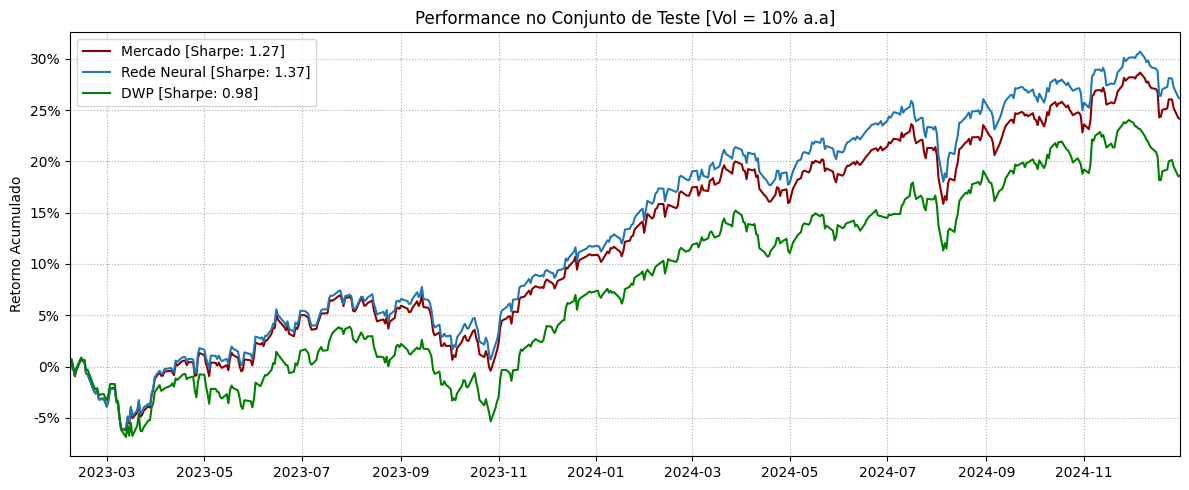

In [23]:
colors = {'Mercado': 'darkred', 'Rede Neural': 'tab:blue', 'DWP': 'green'}

normalized_series = {}
sharpe_ratios = {}

for name, series in series_dict.items():
    # Calculate volatility scaler
    vol_scaler = target_vol / np.std(series) / np.sqrt(252)
    normalized_series[name] = series * vol_scaler
    # Calculate Sharpe ratio
    sharpe_ratios[name] = np.sqrt(252) * np.mean(normalized_series[name]) / np.std(normalized_series[name])

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1)

# Plot each series
for name, series in normalized_series.items():
    label = f'{name} [Sharpe: {sharpe_ratios[name]:.2f}]'
    plt.plot(dates, np.cumsum(series), label=label, linewidth=1.5, color=colors.get(name, None))



# Format plot
plt.grid(linestyle=':')
ax.margins(x=0)
ax.yaxis.set_major_formatter(lambda x, y: f'{x:.0%}')
ax.set_xlabel('')
ax.set_ylabel('Retorno Acumulado')
plt.legend()
plt.title(f'Performance no Conjunto de Teste [Vol = {target_vol:.0%} a.a]')
plt.tight_layout()
plt.grid(True)
plt.show()

In [36]:

# Funções auxiliares para métricas
def annualized_return_log(returns):
    return np.mean(returns) * 252


def sharpe_ratio(returns, risk_free=0.0):
    excess = returns - risk_free
    return np.mean(excess) / np.std(returns) * np.sqrt(252)

def max_drawdown(returns):
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def annualized_volatility(returns):
    return np.std(returns) * np.sqrt(252)

def sortino_ratio(returns, risk_free=0.0):
    downside_returns = returns[returns < risk_free]
    downside_std = np.std(downside_returns)
    if downside_std == 0:
        return np.nan
    return np.mean(returns - risk_free) / downside_std * np.sqrt(252)

def calmar_ratio(returns):
    ret = annualized_return_log(returns)
    mdd = abs(max_drawdown(returns))
    return ret / mdd if mdd != 0 else np.nan

# Calculando as métricas para cada portfólio
metrics = {
    'Retorno Anualizado': {},
    'Sharpe Ratio': {},
    'Sortino Ratio': {},
    'Volatilidade Anualizada': {},
    'Maximum Drawdown': {},
}

for name, returns in series_dict.items():
    metrics['Retorno Anualizado'][name] = annualized_return_log(returns)
    metrics['Sharpe Ratio'][name] = sharpe_ratio(returns)
    metrics['Sortino Ratio'][name] = sortino_ratio(returns)
    metrics['Volatilidade Anualizada'][name] = annualized_volatility(returns)
    metrics['Maximum Drawdown'][name] = max_drawdown(returns)
    # metrics['Calmar Ratio'][name] = calmar_ratio(returns)

# Criar DataFrame
df_metrics = pd.DataFrame(metrics).round(4)


df_metrics


,Retorno Anualizado,Sharpe Ratio,Sortino Ratio,Volatilidade Anualizada,Maximum Drawdown
Mercado,0.1409,1.2699,1.7982,0.1109,-0.0836
Rede Neural,0.1532,1.3746,1.9433,0.1114,-0.0851
DWP,0.1068,0.9803,1.4478,0.1090,-0.0968


In [37]:
print(df_metrics.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Retorno Anualizado & Sharpe Ratio & Sortino Ratio & Volatilidade Anualizada & Maximum Drawdown \\
\midrule
Mercado & 0.140900 & 1.269900 & 1.798200 & 0.110900 & -0.083600 \\
Rede Neural & 0.153200 & 1.374600 & 1.943300 & 0.111400 & -0.085100 \\
DWP & 0.106800 & 0.980300 & 1.447800 & 0.109000 & -0.096800 \\
\bottomrule
\end{tabular}

